In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import pi
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
import orbithunter as orb

# Gluing

The concept of gluing is the foundation for a long sought after ability in turbulence; namely, to use coherent structures
as building blocks for larger turbulent solutions. Any orbits can be used as building blocks in theory, but their combinations may not be *admissible*. This is a theoretical detail that is too complicated to be explained here.

The first step in the gluing is to identify the orbits that we want to glue together; for this introductory example
I'll use the "fundamental periodic orbits"; those of minimal spatiotemporal extent.

In [2]:
keys = (0,1,2)
fpos = ('space_padded/defect', 'default/one_and_half_streak', 'default/wiggle')
td = orb.read_tileset('./data/tiles.h5', keys, fpos)

What do we do with these? To use them as building blocks, we can either manually construct the array of orbits and use the
`glue` function, or, more conveniently, pass an array of symbols; keys of our tile dictionary, and use the `tile` function.
These functions allow us to also pass the Orbit type to return. The 

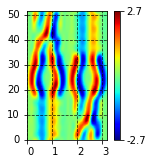

In [3]:
symbol_array = np.array([[0, 1], [2, 2], [1, 0]])
tiled_orbit = orb.tile(symbol_array, td, orb.OrbitKS, include_zeros=False).resize(22, 32).transform(to='modes')
tiled_orbit.plot(padding=True)


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [51.453, 28.407, 0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 4160.518651315871
Target cost tolerance : 1e-06
Maximum iteration number : 1000
-------------------------------------------------------------------------------------------------
#########
------------------------------------------------------------------------------------------------
Starting lsmr optimization
Initial guess : OrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [51.454, 28.636, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 5.036452909887408
Target cost tolerance : 1e-06
Maximum iteration number : 10
-------------------------------------------------------------------------------------------------
#########
Maximum number of iterations reached.  Terminating

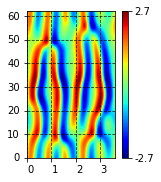

(62.34887131404502, 31.902796955923645)


In [4]:
tiling_result = orb.hunt(tiled_orbit.transform(to='modes').resize(32, 32),
                         maxiter=[1000, 10], methods=('adj', 'lsmr'),
                         verbose=True, preconditioning=[True, False],
                         pexp=(2, 2))
tiling_result.orbit.plot(padding=True)
print(tiling_result.orbit.dimensions())


There are many different ways to use this algorithm; fundamental (smallest) orbits can be used directly to create large
tilings, but this is not the recommended method. Why? As the number of components increases, so does the number of discontinuous boundaries, therefore the spectrum of the final result is polluted by the Gibbs phenomenon. Additionally,
if the dimensions of the tiles are significantly different enough, then the collocation grid becomes more irregular.

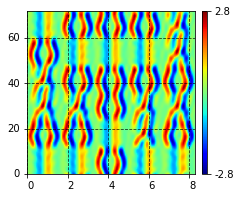

In [5]:
np.random.seed(20)
big_symbol_array = (3*np.random.rand(6, 5)).astype(int)
big_tiling = orb.tile(big_symbol_array, td, orb.OrbitKS, strip_wise=False, gluing_order=(1,0)).resize(32, 48)
big_tiling.plot(padding=True)

Also, to attempt to capture differences in dimension more accurately, the `strip_wise=True` keyword can be passed; it
glues the configuration constitutes in 1-d strips. Once again when the configuration gets too large, orbits can be distorted relative to each other.

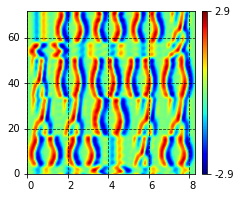

In [6]:
np.random.seed(20)
big_symbol_array = (3*np.random.rand(6, 5)).astype(int)
big_tiling = orb.tile(big_symbol_array, td, orb.OrbitKS, strip_wise=True, gluing_order=(1,0)).resize(48, 64)
big_tiling.plot(padding=True)

In [7]:
big_tiling_result = orb.hunt(big_tiling.transform(to='modes'), verbose=True,
                             preconditioning=[True, False], methods=('adj', 'lsmr'), pexp=(2,2),
                             tol=[1e-4, 1e-4],
                             maxiter=[20000, 1000])


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [47, 62], "basis": "modes", "parameters": [72.034, 73.473, 0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 6459.857046061465
Target cost tolerance : 0.0001
Maximum iteration number : 20000
-------------------------------------------------------------------------------------------------
#######################

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-2f87cdc75789>", line 4, in <module>
    maxiter=[20000, 1000])
  File "C:\Users\Matt\Desktop\orbithunter\orbithunter\optimize.py", line 319, in hunt
    orbit_instance, **hunt_kwargs
  File "C:\Users\Matt\Desktop\orbithunter\orbithunter\optimize.py", line 459, in _adjoint_descent
    gradient = orbit_instance.costgrad(F, **kwargs)
  File "C:\Users\Matt\Desktop\orbithunter\orbithunter\ks\orbits.py", line 709, in costgrad
    grad = self.rmatvec(eqn, **kwargs)
  File "C:\Users\Matt\Desktop\orbithunter\orbithunter\ks\orbits.py", line 664, in rmatvec
    self_field = self.transform(to="field")
  File "C:\Users\Matt\Desktop\orbithunter\orbithunter\ks\orbits.py", line 274, in transform
    return self._inv_spacetime_transform(array=array, inplace=inplace)
  File "C:\Users\

TypeError: object of type 'NoneType' has no len()

In [ ]:
big_tiling_result.orbit.cost()

In [ ]:
big_tiling_result.orbit.plot(padding=True)

Instead of approaching this gluing in a "single step", gluing can be applied iteratively; in other words, it can be
applied using orbits of larger size, not only fundamental orbits. Therefore, we can break the optimization into steps, alternating between `glue` and `hunt`.

Let's use orbits with shift reflection symmetry; for our "tiles" we'll break each orbit into its two fundamental domains.

In [ ]:
larger_tiles = np.array(orb.read_h5("./data/ShiftReflectionOrbitKS.h5"))[[5, 27, 60, 55]]
larger_tileset = orb.rediscretize_tileset(dict(zip(range(4), larger_tiles)), (128, 128))
for k in range(len(larger_tileset)):
    larger_tileset[k].plot()
    larger_tileset[k] = larger_tileset[k].transform(to='field')
    larger_tileset[k+4] = larger_tileset[k].transform(to='field').reflection()

In [ ]:
for k in larger_tileset:
    larger_tileset[k].plot(padding=False, fundamental_domain=True)
    larger_tileset[k] = larger_tileset[k].to_fundamental_domain()

In [ ]:
np.random.seed(28)
large_symbol_array = (4*np.random.rand(3, 5)).astype(int)

large_tiling = orb.tile(large_symbol_array, larger_tileset,
                        orb.OrbitKS, stripwise=False).resize().transform(to='modes')
large_tiling.plot()

In [ ]:
large_tiling.resize(32, 64).plot()

In [ ]:
large_tiling_result = orb.hunt(large_tiling.resize(32, 128), methods=('adj', 'lsmr'), verbose=True,
                               preconditioning=[True, False], maxiter=[50000, 250],
                               ftol=1e-6, scipy_kwargs={"atol":1e-4, "btol":1e-4})
large_tiling_result.orbit.plot(padding=True)

# Expensive pairwise gluing

If the combination of two *specific* orbits is being targeted, then the "expensive pairwise glue" function can be used. This
function searches over all pairs of all members of the group orbit of each constituent. In this example, I'll use two
orbits with discrete symmetry and then return a result with the same symmetry; this requires a special consideration
for this gluing, namely, two halves of one of the orbits must be concatenated in a "double ended queue" style instead
of simply at the end; this is easier to understand when shown visually.

First, import the orbits

In [ ]:
o1, o2 = orb.read_h5('./data/ShiftReflectionOrbitKS.h5', ('t93p804_x22p000','t30p451_x34p465'))
o1, o2 = o1.transform(to="field"), o2.transform(to="field")

In [ ]:
ppo1, ppo2, ppo3 = [x.resize(64, 64).transform(to='field') for x in orb.read_h5("./data/ShiftReflectionOrbitKS.h5",
                    ('t20p505_x21p999', 't28p660_x21p999', 't66p708_x22p007'))]


Let's look at the three orbits to combine using orbithunter's density plots for the KSE.  

In [ ]:
ppo1.plot(), ppo2.plot(), ppo3.plot()

To preserve the shift-reflection symmetry (reflect, translate by half time period), spatial gluing needs to occur
in a special way.

In [ ]:
crude_glued = ppo2.to_fundamental_domain(half=0).concat(ppo1.to_fundamental_domain(half=0), 
                                                        axis=1).from_fundamental_domain().resize(32, 64)
crude_glued.plot()
print(f"{crude_glued.cost()}")

Looking at the gluing above, I think we can do better. This is what the `expensive_pairwise_glue` function is for.

In [ ]:
from orbithunter.gluing import expensive_pairwise_glue
glued = expensive_pairwise_glue(np.array([[ppo1.resize(32, 32)], [ppo2.resize(32, 32)]]),
                                orb.ShiftReflectionOrbitKS, discrete=True, axis=1,
                                fundamental_domain=True)
glued.plot()

By searching the group orbit, we have constructed an initial condition that (to my eye) doesn't appear to have any
discontinuities; compared to the last attempt it looks much better. Quantitatively, we have its cost which is 20 times smaller than the original crude attempt.

In [ ]:
glued.cost()

In [ ]:
result12 = orb.hunt(glued.transform(to='modes'), methods=('adj', 'lstsq'), preconditioning=True)
ppo12 = result12.orbit

Did we do well? Let's check the final cost function value, and then plot the field to ensure that a good result was
returned.

In [ ]:
ppo12.plot()
print(f"The final cost was {ppo12.cost()}")

As previoulsy mentioned, this can be done iteratively. Let's get even bigger!

In [ ]:
ppo12.transform(to='field').resize(32, 32), ppo3.transform(to='field').resize(32, 64)

Because one of the constituents is about twice as large along the spatial axis, it is rediscretized to reflect that. 

In [ ]:
from orbithunter.gluing import expensive_pairwise_glue
glued = expensive_pairwise_glue(np.array([[ppo12.transform(to='field').resize(32, 64)],
                                          [ppo3.transform(to='field').resize(32, 32)]]),
                                orb.ShiftReflectionOrbitKS, discrete=True, axis=1,
                                fundamental_domain=True)
glued.plot(padding=True)

In [ ]:
result123 = orb.hunt(glued.transform(to='modes'), methods=('adj', 'lstsq'), preconditioning=True)
ppo123 = result123.orbit

In [ ]:
result123

In [ ]:
ppo123.plot(padding=True)
print(f"The final cost of the second gluing was {ppo123.cost()}")

I don't think I've ever found a periodic orbit as large as this with as small a residual as this using the random initialization method. Gluing presents us with an informed yet malleable initial conditions with which to search for orbits.
This allows us to attack large spatiotemporal domains, which in turn 